# Gradient descent -- SUGRA potential with 5 parameters and no exponentials

In this file, we

1) Read potentential from an external file

2) Choose the values for the parameters: 
    - Optimizer: e.g. Adam
    - n_points: Number of randomly initialised points
    - n_steps: Maximum number of steps in gradient descent algorithm
    - spread: size of the hypercube with initial data
    - alpha: initial learning rate
    - n_steps_opt: frequency with which the optimizer is rebooted
    - step_stop_opt: step from which the rebooting is cancelled

3) Perform gradient descent

4) Create /Output/ directory if unavailable and store:
    - Cloud of points and loss function into a .npy files
    - Ancillary file stating the choices above and showing the evolution of the learning process

5) Define visualisation functions


=========================

Changes since Oct 31st:

1) Directory of input file with potential changed
2) Number of variables 'dim' not defined in the notebook, but read from the input file

Changes since Nov 6th:

3) Gradient descent updated with optimiser rebooted every few steps

## Gradient Descent

In [1]:
import os
from importlib.machinery import SourceFileLoader

import numpy as np 
import tensorflow as tf

2024-12-05 09:41:34.836225: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-05 09:41:34.853696: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-05 09:41:34.859957: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-05 09:41:34.875277: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-05 09:41:35.865902: W tensorflow/compiler/tf2

In [2]:
##############################
# Parameters
##############################

potential = "pot_5_param_log"                          # .py file with potential function V(x) and the number of variables 'dim'

time = np.datetime_as_string(np.datetime64('now'))
time = time.replace('-','_').replace('T','_at_').replace(':','_')

n_points = 30000                                       # Number of randomly initialised points
n_steps = 40000                                          # Maximum number of steps in gradient descent algorithm
spread = 2.2                                            # Initial values for the cloud of points in the hypercube [-spread/2, spread/2]^dim


alpha=10**(-3)              # Initial learning rate
n_steps_opt = 200           # Number of steps before rebooting optimizer
step_stop_opt = 1        


optimizer = tf.keras.optimizers.Adam(learning_rate=alpha)

optimizer_info = optimizer.get_config()

I0000 00:00:1733388099.774020   42589 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733388099.819329   42589 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733388099.819654   42589 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733388099.821194   42589 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [ ]:
print(time)

2024_12_05_at_08_41_39


In [4]:
# Saving directory
out_dir = os.getcwd()+'/Output/'

try:
    os.mkdir(out_dir)
    print(f"Directory '{out_dir}' created successfully.")
except FileExistsError:
    print(f"Directory '{out_dir}' already exists.")
except PermissionError:
    print(f"Permission denied: Unable to create '{out_dir}'.")
except Exception as e:
    print(f"An error occurred: {e}")


# Output File names
attempt = f"_{potential}_{n_points}_{time}"

info_file = out_dir + 'Comments' + attempt + '.txt'
data_file = out_dir + 'Points' + attempt + '.npy'
loss_file = out_dir + 'Loss' + attempt + '.npy'


f_info = open(info_file, 'w')


f_info.write(f'File created on {time}')
f_info.write(f'\n\nPotential : {potential}')
f_info.write(f'\nNumber of points: {n_points}')
f_info.write(f'\nNumber of steps: {n_steps}\n')
f_info.write(f'\nn_steps_opt: {n_steps_opt}\n')
f_info.write(f'\nstep_stop_opt: {step_stop_opt}\n')
f_info.write('\nOptimizer:\n')


for key, value in optimizer_info.items(): 
    f_info.write('  - %s : %s\n' % (key, value))

f_info.write('\nEvolution:')
f_info.flush()

Directory '/home/camille/Documents/Science/MLFlatDirections/Output/' already exists.


In [5]:
# Loading the potential
module = SourceFileLoader(potential,os.getcwd()+'/Potential_generator/'+potential+'.py').load_module()
V = module.V
dim = module.dim

print(dim)
help(V)

5
Help on function V in module pot_5_param_log:

V(x)
    0.5 * (ex7 ** 6 -4 * (-1 + x1 ** 2 + x2 ** 2 + x3 ** 2) + (ex7 ** -6) * ((x1 ** 2 + x2 ** 2 + x3 ** 2) ** 2) + 2 * (ex7 ** -4) * (ex9 ** (-2 * (3 ** -0.5))) * ((ex9 ** (np.sqrt(3))) * (x1 ** 2 + x2 ** 2) + x3 ** 2) + 2 * (ex7 ** 4) * (ex9 ** (-(3 ** -0.5))) * (x1 ** 2 + x2 ** 2 + (ex9 ** (np.sqrt(3))) * (x3 ** 2)) + (ex7 ** 2) * (ex9 ** (-2 * (3 ** -0.5))) * (-2 + x1 ** 4 + 2 * (x1 ** 2) * (x2 ** 2) + x2 ** 4 + (ex9 ** (2 * (np.sqrt(3)))) * (x3 ** 4) + 2 * (ex9 ** (np.sqrt(3))) * (-2 + (x1 ** 2) * (x3 ** 2) + (x2 ** 2) * (x3 ** 2))) + (ex7 ** -2) * (ex9 ** (-4 * (3 ** -0.5))) * (1 -2 * (ex9 ** (2 * (np.sqrt(3)))) * (x3 ** 2) * (x1 ** 2 + x2 ** 2 + x3 ** 2) -2 * (ex9 ** (np.sqrt(3))) * (2 + x1 ** 4 + x2 ** 4 + (x2 ** 2) * (x3 ** 2) + (x1 ** 2) * (2 * (x2 ** 2) + x3 ** 2))))



In [6]:
# compute (||∇V||^2)
def grad_norm_squared(V, x):
    
    # Record operations for automatic differentiation:
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = V(x)                                     # compute V at each point
    gradients = tape.gradient(loss, x)                  # compute ∇V at each point
    norm_squared = tf.reduce_sum(gradients**2, axis=1)  # ||∇V||^2 at each point
    return norm_squared

In [7]:
# Randomly initialize the points
x = tf.Variable(np.random.rand(n_points, dim)+1, dtype=tf.float32)


loss_history = []


# Learning loop 
for step in range(n_steps):  
    with tf.GradientTape() as tape:
        loss = tf.reduce_sum(grad_norm_squared(V, x))  # minimize ||∇V||^2 for all points
        loss_history.append(loss)
    
    # Compute ||∇V||^2 with respect to x
    gradients = tape.gradient(loss, [x])
        
    # Apply gradient descent for all points
    optimizer.apply_gradients(zip(gradients, [x]))
    
    # Update the information in info file
    if step % 500 == 0:
        f_info.write(f"\n  Step {step}: ||∇V||^2 = {loss.numpy()}")
        f_info.flush()
        
    if np.log(loss.numpy())/np.log(10)<-6: 
        f_info.write("\n\nConverged enough") 
        f_info.write(f"\n  Step {step}: ||∇V||^2 = {loss.numpy()}")
        break

f_info.close()

# Saving loss and final cloud of points
np.save(data_file,x)
np.save(loss_file,loss_history)

In [ ]:
# # Randomly initialize the points
# x = tf.Variable(np.random.rand(n_points, 3)+1, dtype=tf.float32)


# loss_history = []

# update_opt = False


# # Learning loop 
# for step in range(n_steps):  
#     with tf.GradientTape() as tape:
#         loss = tf.reduce_sum(grad_norm_squared(V, x))  # minimize ||∇V||^2 for all points
#         loss_history.append(loss)
    
#     # Compute ||∇V||^2 with respect to x
#     gradients = tape.gradient(loss, [x])
        
#     # Apply gradient descent for all points
#     optimizer.apply_gradients(zip(gradients, [x]))
    
#     # Updates of optimizer
#     if update_opt and step % n_steps_opt ==0 :
#         print("Reinitializing the optimizer")
#         optimizer = tf.optimizers.Adam(learning_rate=alpha)

#     if step == step_stop_opt:
#         update_opt = False
    
#     if (step - step_stop_opt)%(3*n_steps_opt) == 0:
#         alpha = alpha/10
#         optimizer = tf.optimizers.Adam(learning_rate=alpha)


#     # Update the information in info file
#     if step % 500 == 0:
#         f_info.write(f"\n  Step {step}: ||∇V||^2 = {loss.numpy()}")
#         f_info.flush()
        
#     if np.log(loss.numpy())/np.log(10)<-8: 
#         f_info.write("\n\nConverged enough") 
#         f_info.write(f"\n  Step {step}: ||∇V||^2 = {loss.numpy()}")
#         break

# f_info.close()

# # Saving loss and final cloud of points
# np.save(data_file,x)
# np.save(loss_file,loss_history)

## Results

In [1]:
import os
from importlib.machinery import SourceFileLoader

import numpy as np 
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm

import tensorflow as tf

2024-12-10 19:12:53.486438: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-10 19:12:53.513723: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-10 19:12:53.522007: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 19:12:53.541378: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-10 19:12:55.057148: W tensorflow/compiler/tf2

### Functions

In [2]:
# compute (||∇V||^2)
def grad_norm_squared(V, x):
    
    # Record operations for automatic differentiation:
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = V(x)                                     # compute V at each point
    gradients = tape.gradient(loss, x)                  # compute ∇V at each point
    norm_squared = tf.reduce_sum(gradients**2, axis=1)  # ||∇V||^2 at each point
    return norm_squared

In [3]:
def triangular_plot(chains):
    data=chains
    nsteps,ndim=chains.shape
    fig = plt.figure(figsize=(20,20))
    for i in range(ndim):
        ax = fig.add_subplot(ndim,ndim,i*ndim+i+1)
        
        ax.hist(data[:,i], 100, color="k", histtype="step")
        ax.set_title(f"x{i+1} counts")

    for i in range(ndim):
        for j in range(i):
            ax = fig.add_subplot(ndim,ndim,i*ndim+j+1)
            counts,xbins,ybins,image = ax.hist2d(data[:,j],data[:,i],bins=100, norm=LogNorm(), cmap = plt.cm.rainbow)
            plt.colorbar(image)
            ax.contour(counts.transpose(),extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]], linewidths=0.5, cmap = plt.cm.rainbow, levels = [1,100,1000,10000])
            ax.set_xlabel(f'x{j+1}')
            ax.set_ylabel(f'x{i+1}')
    plt.show()
    
# def triangular_plot(chains,figname):
#     data=chains
#     nsteps,ndim=chains.shape
#     fig = plt.figure(figsize=(20,20))
#     for i in range(ndim):
#         ax = fig.add_subplot(ndim,ndim,i*ndim+i+1)
        
#         ax.hist(data[:,i], 100, color="k", histtype="step")
#         ax.set_title(f"x{i+1} counts")

#     for i in range(ndim):
#         for j in range(i):
#             ax = fig.add_subplot(ndim,ndim,i*ndim+j+1)
#             counts,xbins,ybins,image = ax.hist2d(data[:,j],data[:,i],bins=100, norm=LogNorm(), cmap = plt.cm.rainbow)
#             plt.colorbar(image)
#             ax.contour(counts.transpose(),extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]], linewidths=0.5, cmap = plt.cm.rainbow, levels = [1,100,1000,10000])
#             ax.set_xlabel(f'x{j+1}')
#             ax.set_ylabel(f'x{i+1}')
#     plt.savefig(figname)
#     plt.show()


def triangular_plot_slopes(chains):
    data=chains.numpy()
    nsteps,ndim=chains.shape
    fig = plt.figure(figsize=(15,15))
    for i in range(ndim):
        for j in range(i):
            ax=fig.add_subplot(ndim,ndim,ndim*i+j+1)
            those_slope0=np.extract(np.abs(data[:,0])>0.2,data[:,i]/data[:,j])
            those_slope=np.extract(np.abs(those_slope0)<10,those_slope0)
            ax.hist(those_slope,bins=100)
            ax.set_title(f"x{j}/x{i}")
    plt.show()

### Analysis

In [7]:
# Loading the potential
potential = "pot_5_param_log"                         # .py file with potential function V(x)
module = SourceFileLoader(potential,os.getcwd()+'/Potential_generator/'+potential+'.py').load_module()
V = module.V
dim = module.dim


out_dir = os.getcwd()+'/Output/'
time = '2024_12_05_at_08_41_39'
n_points = 30000

attempt = f"_{potential}_{n_points}_{time}"

data_file = out_dir + 'Points' + attempt + '.npy'
loss_file = out_dir + 'Loss' + attempt + '.npy'

In [8]:

x = tf.Variable(np.load(data_file), dtype=tf.float32)
loss_history = np.load(loss_file)

I0000 00:00:1733851943.160550   39623 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733851943.216385   39623 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733851943.216742   39623 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733851943.218329   39623 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [9]:
for i in range(15):
    print(f"Number of points with ||∇V||^2 > {10**(-i)} : {sum(grad_norm_squared(V,x).numpy()>10**(-i))}")

Number of points with ||∇V||^2 > 1 : 2
Number of points with ||∇V||^2 > 0.1 : 4
Number of points with ||∇V||^2 > 0.01 : 9
Number of points with ||∇V||^2 > 0.001 : 15
Number of points with ||∇V||^2 > 0.0001 : 72
Number of points with ||∇V||^2 > 1e-05 : 357
Number of points with ||∇V||^2 > 1e-06 : 1067
Number of points with ||∇V||^2 > 1e-07 : 1895
Number of points with ||∇V||^2 > 1e-08 : 2700
Number of points with ||∇V||^2 > 1e-09 : 4196
Number of points with ||∇V||^2 > 1e-10 : 6146
Number of points with ||∇V||^2 > 1e-11 : 9887
Number of points with ||∇V||^2 > 1e-12 : 20076
Number of points with ||∇V||^2 > 1e-13 : 27479
Number of points with ||∇V||^2 > 1e-14 : 29329


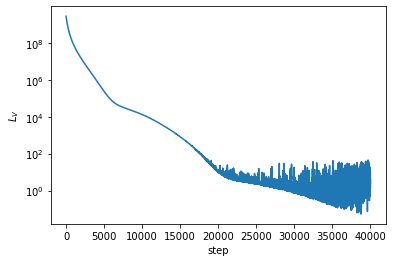

In [10]:
plt.figure(1)
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('step')
plt.ylabel('$L_{V}$')
plt.show()

<Figure size 432x288 with 0 Axes>

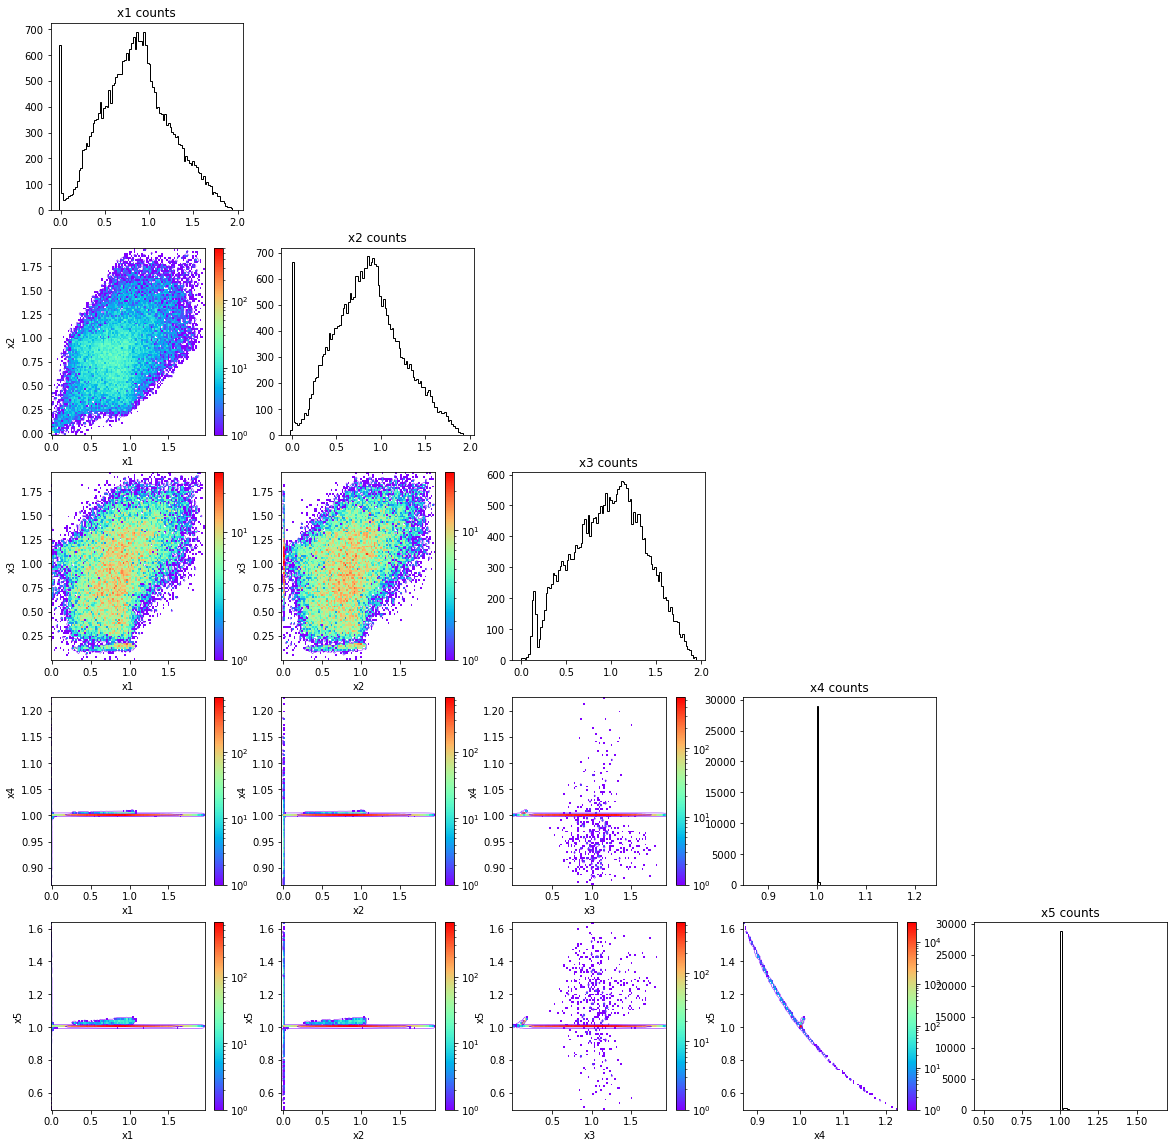

In [11]:
plt.figure(1)
triangular_plot(x.numpy())


## Autoencoder

In [4]:
import os
from importlib.machinery import SourceFileLoader


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model

In [5]:
# Loading the potential
potential = "pot_5_param_log"                         # .py file with potential function V(x)
module = SourceFileLoader(potential,os.getcwd()+'/Potential_generator/'+potential+'.py').load_module()
V = module.V
dim = module.dim


out_dir = os.getcwd()+'/Output/'
time = '2024_12_05_at_08_41_39'
n_points = 30000

attempt = f"_{potential}_{n_points}_{time}"

data_file = out_dir + 'Points' + attempt + '.npy'
loss_file = out_dir + 'Loss' + attempt + '.npy'

In [6]:
x = np.load(data_file)
loss_history = np.load(loss_file)

In [7]:
x_train, x_test = train_test_split(x, test_size=0.15, random_state=42)

In [8]:
print(f'shape of total set of points: {x.shape}')
print(f'shape of training set of points: {x_train.shape}')
print(f'shape of validation set of points: {x_test.shape}')

shape of total set of points: (30000, 5)
shape of training set of points: (25500, 5)
shape of validation set of points: (4500, 5)


### Latent dimension = 1

In [9]:
input_dim = dim  
latent_dim = 1  

# Encoder
inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(32, activation='sigmoid')(inputs)
encoded = layers.Dense(16, activation='sigmoid')(encoded)
encoded = layers.Dense(8, activation='sigmoid')(encoded)
encoded = layers.Dense(latent_dim)(encoded)  

# Decoder
decoded = layers.Dense(8, activation='sigmoid')(encoded)
decoded = layers.Dense(16, activation='sigmoid')(decoded)
decoded = layers.Dense(32, activation='sigmoid')(decoded)
decoded = layers.Dense(input_dim)(decoded)  

# Autoencoder 
autoencoder = models.Model(inputs, decoded)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=optimizer, loss='mse')

I0000 00:00:1733854388.510046   19974 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733854388.557732   19974 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733854388.558054   19974 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733854388.559874   19974 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [10]:
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,734 (6.77 KB)

 Trainable params: 1,734 (6.77 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
epochs = 3000
history_AE_1 = autoencoder.fit(x_train, x_train, epochs=epochs, batch_size=100, shuffle=True,validation_data=(x_test, x_test))

Epoch 1/3000


I0000 00:00:1733854397.591575   23679 service.cc:146] XLA service 0x781ff800f550 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733854397.591596   23679 service.cc:154]   StreamExecutor device (0): Quadro T2000 with Max-Q Design, Compute Capability 7.5
2024-12-10 19:13:17.654822: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-10 19:13:17.987607: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 70/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0130

I0000 00:00:1733854400.227490   23679 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


255/255 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.8466 - val_loss: 0.3605
Epoch 2/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2850 - val_loss: 0.1464
Epoch 3/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1278 - val_loss: 0.0997
Epoch 4/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0959 - val_loss: 0.0936
Epoch 5/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0921 - val_loss: 0.0932
Epoch 6/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0918 - val_loss: 0.0932
Epoch 7/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0916 - val_loss: 0.0932
Epoch 8/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0920 - val_loss: 0.0932
Epoch 9/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0928 - val_loss: 0.0932
Epoch 10/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0922 - val_loss: 0.0932
Epoch 11/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0921 - val_loss: 0.0932
Epoch 12/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 

In [12]:
autoencoder_1 = autoencoder
encoder_1 = models.Model(inputs,encoded)
decoder_1 = models.Model(encoded,decoded)

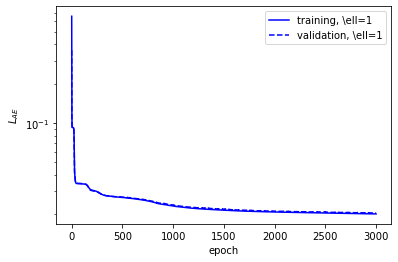

In [13]:
plt.plot(history_AE_1.history['loss'], label='training, \ell=1',color='blue')
plt.plot(history_AE_1.history['val_loss'], label='validation, \ell=1',color='blue',linestyle='--')
plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('$L_{AE}$')
plt.legend()

### Latent dimension = 2

In [14]:
input_dim = dim  
latent_dim = 2

# Encoder
inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(32, activation='sigmoid')(inputs)
encoded = layers.Dense(16, activation='sigmoid')(encoded)
encoded = layers.Dense(8, activation='sigmoid')(encoded)
encoded = layers.Dense(latent_dim)(encoded)  

# Decoder
decoded = layers.Dense(8, activation='sigmoid')(encoded)
decoded = layers.Dense(16, activation='sigmoid')(decoded)
decoded = layers.Dense(32, activation='sigmoid')(decoded)
decoded = layers.Dense(input_dim)(decoded)  

# Autoencoder 
autoencoder = models.Model(inputs, decoded)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=optimizer, loss='mse')

In [15]:
autoencoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,751 (6.84 KB)

 Trainable params: 1,751 (6.84 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
epochs = 3000
history_AE_2 = autoencoder.fit(x_train, x_train, epochs=epochs, batch_size=100, shuffle=True,validation_data=(x_test, x_test))

Epoch 1/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 1.5491 - val_loss: 0.7683
Epoch 2/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6171 - val_loss: 0.2965
Epoch 3/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2432 - val_loss: 0.1395
Epoch 4/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1251 - val_loss: 0.1006
Epoch 5/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0966 - val_loss: 0.0939
Epoch 6/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0921 - val_loss: 0.0932
Epoch 7/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0921 - val_loss: 0.0932
Epoch 8/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0913 - val_loss: 0.0932
Epoch 9/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0921 - val_loss: 0.0932
Epoch 10/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0930 - val_loss: 0.0932
Epoch 11/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0926 - val_loss: 0.0932
Epoch 12/3000
255/255 ━━━━━━━━

In [17]:
autoencoder_2 = autoencoder
encoder_2 = models.Model(inputs,encoded)
decoder_2 = models.Model(encoded,decoded)

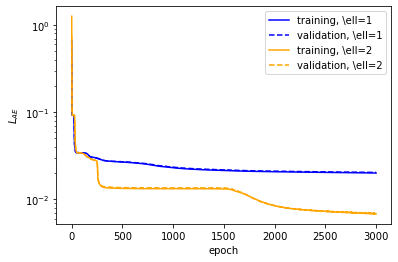

In [18]:
plt.plot(history_AE_1.history['loss'], label='training, \ell=1',color='blue')
plt.plot(history_AE_1.history['val_loss'], label='validation, \ell=1',color='blue',linestyle='--')
plt.plot(history_AE_2.history['loss'], label='training, \ell=2',color='orange')
plt.plot(history_AE_2.history['val_loss'], label='validation, \ell=2',color='orange',linestyle='--')
plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('$L_{AE}$')
plt.legend()

In [19]:
# test autoencoder
encoded_points = encoder_2.predict(x_test)

141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


### Latent dimension = 3

In [20]:
input_dim = dim  
latent_dim = 3

# Encoder
inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(32, activation='sigmoid')(inputs)
encoded = layers.Dense(16, activation='sigmoid')(encoded)
encoded = layers.Dense(8, activation='sigmoid')(encoded)
encoded = layers.Dense(latent_dim)(encoded)  

# Decoder
decoded = layers.Dense(8, activation='sigmoid')(encoded)
decoded = layers.Dense(16, activation='sigmoid')(decoded)
decoded = layers.Dense(32, activation='sigmoid')(decoded)
decoded = layers.Dense(input_dim)(decoded)  

# Autoencoder 
autoencoder = models.Model(inputs, decoded)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=optimizer, loss='mse')

In [21]:
autoencoder.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 3)              │            27 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 8)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,768 (6.91 KB)

 Trainable params: 1,768 (6.91 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
epochs = 3000
history_AE_3 = autoencoder.fit(x_train, x_train, epochs=epochs, batch_size=100, shuffle=True,validation_data=(x_test, x_test))

Epoch 1/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.9395 - val_loss: 0.4376
Epoch 2/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3522 - val_loss: 0.1798
Epoch 3/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1533 - val_loss: 0.1082
Epoch 4/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1019 - val_loss: 0.0948
Epoch 5/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0922 - val_loss: 0.0933
Epoch 6/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0918 - val_loss: 0.0932
Epoch 7/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0919 - val_loss: 0.0932
Epoch 8/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0917 - val_loss: 0.0931
Epoch 9/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0912 - val_loss: 0.0932
Epoch 10/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0921 - val_loss: 0.0931
Epoch 11/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0925 - val_loss: 0.0931
Epoch 12/3000
255/255 ━━━━━━━━

In [23]:
autoencoder_3 = autoencoder
encoder_3 = models.Model(inputs,encoded)
decoder_3 = models.Model(encoded,decoded)

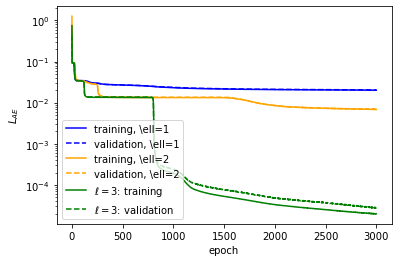

In [24]:
plt.plot(history_AE_1.history['loss'], label='training, \ell=1',color='blue')
plt.plot(history_AE_1.history['val_loss'], label='validation, \ell=1',color='blue',linestyle='--')
plt.plot(history_AE_2.history['loss'], label='training, \ell=2',color='orange')
plt.plot(history_AE_2.history['val_loss'], label='validation, \ell=2',color='orange',linestyle='--')
plt.plot(history_AE_3.history['loss'], label='$\ell=3$: training',color='green')
plt.plot(history_AE_3.history['val_loss'], label='$\ell=3$: validation',color='green',linestyle='--')

plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('$L_{AE}$')
plt.legend()

plt.show()

# plt.savefig('../LaTeX/Notes/Figures/lossAE_higgs.png')

### Latent dimension = 4

In [25]:
input_dim = dim  
latent_dim = 4

# Encoder
inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(32, activation='sigmoid')(inputs)
encoded = layers.Dense(16, activation='sigmoid')(encoded)
encoded = layers.Dense(8, activation='sigmoid')(encoded)
encoded = layers.Dense(latent_dim)(encoded)  

# Decoder
decoded = layers.Dense(8, activation='sigmoid')(encoded)
decoded = layers.Dense(16, activation='sigmoid')(decoded)
decoded = layers.Dense(32, activation='sigmoid')(decoded)
decoded = layers.Dense(input_dim)(decoded)  

# Autoencoder 
autoencoder = models.Model(inputs, decoded)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=optimizer, loss='mse')

In [26]:
autoencoder.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 32)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,785 (6.97 KB)

 Trainable params: 1,785 (6.97 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
epochs = 3000
history_AE_4 = autoencoder.fit(x_train, x_train, epochs=epochs, batch_size=100, shuffle=True,validation_data=(x_test, x_test))

Epoch 1/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.0319 - val_loss: 0.4895
Epoch 2/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3892 - val_loss: 0.1872
Epoch 3/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1576 - val_loss: 0.1069
Epoch 4/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1009 - val_loss: 0.0943
Epoch 5/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0919 - val_loss: 0.0932
Epoch 6/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0909 - val_loss: 0.0932
Epoch 7/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0913 - val_loss: 0.0932
Epoch 8/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0924 - val_loss: 0.0932
Epoch 9/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0922 - val_loss: 0.0932
Epoch 10/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0923 - val_loss: 0.0931
Epoch 11/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0920 - val_loss: 0.0931
Epoch 12/3000
255/255 ━━━━━━━━

In [28]:
autoencoder_4 = autoencoder
encoder_4 = models.Model(inputs,encoded)
decoder_4 = models.Model(encoded,decoded)

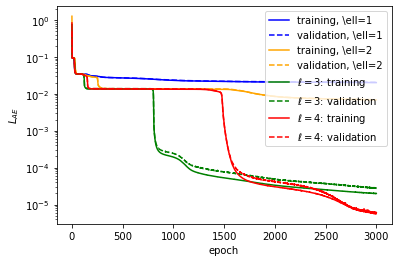

In [34]:
plt.plot(history_AE_1.history['loss'], label='training, \ell=1',color='blue')
plt.plot(history_AE_1.history['val_loss'], label='validation, \ell=1',color='blue',linestyle='--')
plt.plot(history_AE_2.history['loss'], label='training, \ell=2',color='orange')
plt.plot(history_AE_2.history['val_loss'], label='validation, \ell=2',color='orange',linestyle='--')
plt.plot(history_AE_3.history['loss'], label='$\ell=3$: training',color='green')
plt.plot(history_AE_3.history['val_loss'], label='$\ell=3$: validation',color='green',linestyle='--')
plt.plot(history_AE_4.history['loss'], label='$\ell=4$: training',color='red')
plt.plot(history_AE_4.history['val_loss'], label='$\ell=4$: validation',color='red',linestyle='--')

plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('$L_{AE}$')
plt.legend()

plt.show()

# plt.savefig('../LaTeX/Notes/Figures/lossAE_higgs.png')

### Latent dimension = 5

In [30]:
input_dim = dim  
latent_dim = 5

# Encoder
inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(32, activation='sigmoid')(inputs)
encoded = layers.Dense(16, activation='sigmoid')(encoded)
encoded = layers.Dense(8, activation='sigmoid')(encoded)
encoded = layers.Dense(latent_dim)(encoded)  

# Decoder
decoded = layers.Dense(8, activation='sigmoid')(encoded)
decoded = layers.Dense(16, activation='sigmoid')(decoded)
decoded = layers.Dense(32, activation='sigmoid')(decoded)
decoded = layers.Dense(input_dim)(decoded)  

# Autoencoder 
autoencoder = models.Model(inputs, decoded)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=optimizer, loss='mse')

In [31]:
autoencoder.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 32)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 5)              │            45 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 8)              │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,802 (7.04 KB)

 Trainable params: 1,802 (7.04 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
epochs = 3000
history_AE_5 = autoencoder.fit(x_train, x_train, epochs=epochs, batch_size=100, shuffle=True,validation_data=(x_test, x_test))

Epoch 1/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.4327 - val_loss: 0.1496
Epoch 2/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1253 - val_loss: 0.0951
Epoch 3/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0933 - val_loss: 0.0932
Epoch 4/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0914 - val_loss: 0.0932
Epoch 5/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0926 - val_loss: 0.0932
Epoch 6/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0920 - val_loss: 0.0932
Epoch 7/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0921 - val_loss: 0.0931
Epoch 8/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0922 - val_loss: 0.0931
Epoch 9/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0920 - val_loss: 0.0931
Epoch 10/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0918 - val_loss: 0.0931
Epoch 11/3000
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0916 - val_loss: 0.0931
Epoch 12/3000
255/255 ━━━━━━━━

In [ ]:
autoencoder_5 = autoencoder
encoder_5 = models.Model(inputs,encoded)
decoder_5 = models.Model(encoded,decoded)

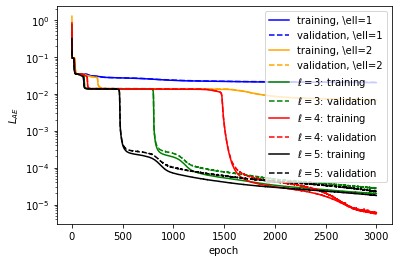

In [33]:
plt.plot(history_AE_1.history['loss'], label='training, \ell=1',color='blue')
plt.plot(history_AE_1.history['val_loss'], label='validation, \ell=1',color='blue',linestyle='--')
plt.plot(history_AE_2.history['loss'], label='training, \ell=2',color='orange')
plt.plot(history_AE_2.history['val_loss'], label='validation, \ell=2',color='orange',linestyle='--')
plt.plot(history_AE_3.history['loss'], label='$\ell=3$: training',color='green')
plt.plot(history_AE_3.history['val_loss'], label='$\ell=3$: validation',color='green',linestyle='--')
plt.plot(history_AE_4.history['loss'], label='$\ell=4$: training',color='red')
plt.plot(history_AE_4.history['val_loss'], label='$\ell=4$: validation',color='red',linestyle='--')
plt.plot(history_AE_5.history['loss'], label='$\ell=5$: training',color='black')
plt.plot(history_AE_5.history['val_loss'], label='$\ell=5$: validation',color='black',linestyle='--')

plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('$L_{AE}$')
plt.legend()

plt.show()

# plt.savefig('../LaTeX/Notes/Figures/lossAE_higgs.png')